In [32]:
import torch; print(torch.cuda.is_available())

True


# MTH 5320 / 4320 Project 1. Duck R-CNN

This project is in collaboration with the Florida Tech IEEE Southeast Con Hardware Team. They are constructing a robot for the upcoming IEEE Southeast Con Hardware Competition, where competing schools create automated robots to perform tasks. This years task partially involves locating, and collecting a series of "Astroducks" as seen below

![just the duck](results/image.png "The Astroduck")

Since the robot has to be small, we ideally will have to run this on extremely low power hardware. We also need to guarantee that even if we run on low power hardware, that our model will be performant enough to run in real time, thus ensuring that the robot has an accurate awareness of its surroundings. This enforces our largest constraint: Our model needs to be incredibly small. To this end, we decided to implement completely from scratch, that way we would have complete control over the model size, and tune it to exactly our problemset. 

Since we are implementing an R-CNN we have two models at play. The Region Proposal Network (RPN) and the classifier. We initially tried training these both simulatneously, but this balooned in complexity incredibly quickly. Therefore we trained them seperately, and combine them at the end into one total architecture. 

However, we took a slightly different approach to a traditional RCNN. In traditional R-CNN architectures, the Region Proposal Network (RPN) and the classifier are trained jointly as part of a single end-to-end network, sharing the same feature extraction layers. We encountered a number of issues in getting this joint setup running reliably, so we adopted a simplified approach: both networks use the same feature extraction architecture (we called "backbone"), but they were trained separately. At inference time, the two trained models are combined effectively resulting in two independent backbones, one used by the RPN and the other by the classifier.

In [64]:
# Get the imports out of the way.

import os
import csv
import math
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.ops import nms, box_iou
from sklearn.metrics import confusion_matrix, classification_report
import functools

In [34]:
IMAGE_SIZE = 128
LABELS = ['background', 'duck', 'duck_on_side']
NUM_CLASSES = len(LABELS)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
# Basic helper functions

def string_to_label(label):
    return LABELS.index(label.lower())

def train_val_split(dataset, val_ratio=0.1, seed=12345):
    n_val = int(len(dataset) * val_ratio)
    n_train = len(dataset) - n_val
    generator = torch.Generator().manual_seed(seed)
    return random_split(dataset, [n_train, n_val], generator=generator)

Here we define our two datasets. One for the classifier, and one for the RPN network. The classifier will use the "crop" dataset, which will use the labeled bounding boxes, and crop / resize them so that only the object is in view. I.e. the diagram below

![just the duck](results/ducky.png "Sample Classifier Dataset Sample")

In [36]:
# Classifier dataset. 
class DuckCropDataset(Dataset):
    def __init__(self, image_dir, image_size=IMAGE_SIZE):
        self.samples = []

        # Resize to square aspect ratio for simplicity. 
        self.tform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
        ])

        for root, _, files in os.walk(image_dir):
            for f in files:

                if f.lower().split('.')[-1] not in ['jpg','jpeg','png']:
                    continue # This is not an image file. Continue. 

                img_path = os.path.join(root, f)
                csv_path = img_path.rsplit('.', 1)[0] + '.csv' # Replace image filetype with .csv to get corresponding csv path.
                if not os.path.exists(csv_path): 
                    continue # Csv does not exist? This must be an un-labeled sample. Ignore it. 

                with open(csv_path, newline="") as cf:
                    reader = csv.DictReader(cf)

                    # Note that the loop below creates multiple samples per image, which is how we keep the __getitem__ as clean as it is. 
                    for row in reader: # Loop over every label
                        cls = row["class"].strip().lower()
                        if cls not in LABELS: continue # invalid label. Ignore
                        x, y, w, h = map(float, [row["x"], row["y"], row["width"], row["height"]])
                        self.samples.append((img_path, x, y, w, h, string_to_label(cls))) # Create a new entry per label. 
            
        print("Number of samples: ", len(self.samples))

    def __len__(self):
        return len(self.samples)

    @functools.lru_cache(maxsize=5000)
    def __getitem__(self, idx):
        img_path, x, y, w, h, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB") # Load the image. 
        crop = img.crop((x, y, x+w, y+h)) # Crop just the bounding box from the image.
        # Resize the image to the target image size using the tform, and return the image tensor, and the label tensor.  
        return self.tform(crop), torch.tensor(label, dtype=torch.long)

# RPN Dataset
class DuckRegionDataset(Dataset):
    def __init__(self, image_dir, image_size=IMAGE_SIZE, augment=False):
        self.samples = []

        # Resize to square aspect ratio for simplicity. 
        self.tform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
        ])

        for root, _, files in os.walk(image_dir):
            for f in files:
                if f.lower().split('.')[-1] not in ['jpg','jpeg','png']:
                    continue # This is not an image file. Continue. 

                img_path = os.path.join(root, f)
                csv_path = img_path.rsplit('.', 1)[0] + '.csv' # Replace image filetype with .csv to get corresponding csv path.
                if not os.path.exists(csv_path): 
                    continue # Csv does not exist? This must be an un-labeled sample. Ignore it. 

                boxes = []
                with open(csv_path, newline='') as cf:
                    reader = csv.DictReader(cf)
                    for row in reader:
                        cls = row["class"].strip().lower()

                        if cls not in LABELS:
                            continue # Invalid label. Ingore

                        if cls == 'background':
                            continue # Ignore all the background labels, since we wanna find objects in the scene. 

                        x, y, w, h = map(float, [row["x"], row["y"], row["width"], row["height"]])
                        boxes.append([x, y, x + w, y + h]) # Build a list of all the bounding boxes in this image. 
                        # Note that we are discarding the label here. Since this dataset is just for identifying where things are, not what they are. 

                self.samples.append((img_path, boxes))

    def __len__(self):
        return len(self.samples)

    @functools.lru_cache(maxsize=5000)
    def __getitem__(self, idx):
        img_path, boxes = self.samples[idx]
        img = Image.open(img_path).convert("RGB") # load the image. 
        W0, H0 = img.size # Get the image size. Should be 640 x 480
        tensor = self.tform(img) # Resize, and convert to tensor. 
        _, H1, W1 = tensor.shape # Get final resize shape. Should be 128 x 128 (or whatevefr the image size is)

        if boxes:
            b = torch.tensor(boxes, dtype=torch.float32)
            b[:, [0, 2]] *= (W1 / W0) # Adapt box sizes over to new aspect ratio & size. 
            b[:, [1, 3]] *= (H1 / H0)
        else:
            b = torch.zeros((0, 4), dtype=torch.float32)
        target = {"boxes": b}
        return tensor, target

## Backbone Code

This is where we get to the model implementation. For our feature extractor backbone, we created a custom network loosely based on ResNet. This model was of course greatly slimmed down, as our backbone only has about 30k params. Each stage progressively downsamples the input while increasing the number of feature channels, allowing the model to capture both low-level spatial details and high-level semantic information. And, since we are using residual blocks we can avoid the exploding / vanishing gradient problem. 

In [37]:


class ConvBlock(nn.Module):
    """Conv-BN-ReLU convenience block"""
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): 
        return self.block(x)

class ResidualBlock(nn.Module):
    """Simple residual block (like a small ResNet layer)"""
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + residual)

class TinyBackbone(nn.Module):
    """A small ResNet-ish backbone"""
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(ConvBlock(3, 8, 2), ResidualBlock(8))
        self.stage2 = nn.Sequential(ConvBlock(8, 16, 2), ResidualBlock(16))
        self.stage3 = nn.Sequential(ConvBlock(16, 32, 2), ResidualBlock(32))
        # self.stage4 = nn.Sequential(ConvBlock(64, 128, 2), ResidualBlock(128))
        self.out_channels = 32

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        # x = self.stage4(x)
        return x


## Classifier Code

Now that we have the backbone, we can implement the duck classifier using the backbone feature extractor. 

In [38]:
class DuckClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = TinyBackbone() # Feature extractor. 
        self.pool = nn.AdaptiveAvgPool2d((1,1)) # Compress each feature map to one value. 
        self.fc = nn.Linear(self.backbone.out_channels, num_classes) # Linear to the output. 

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        return self.fc(x) # Return the raw logits, so that we can have precise control over the loss later. 

## Classifier Training

Now we can implement our training loop like so. We implemented early stopping at 10 iterations to prevent overfitting, and make the model faster to train. 

In [39]:
# Grid Search params. 

BATCH_SIZES = [32, 64, 128, 256]
LRS = [5e-4, 1e-4, 5e-5 ]
MAX_EPOCHS = 500
PATIENCE = 10

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0005 batch size = 32
Early stopping.


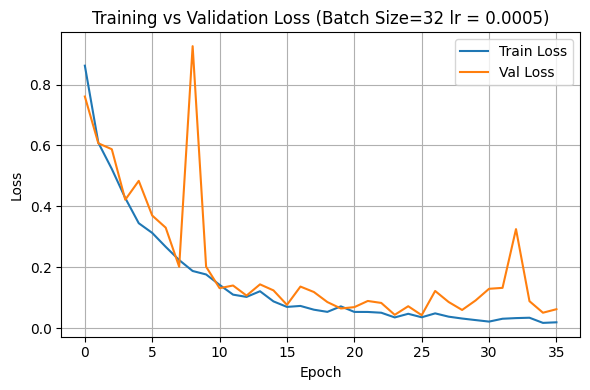

New record!
Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0005 batch size = 64
Early stopping.


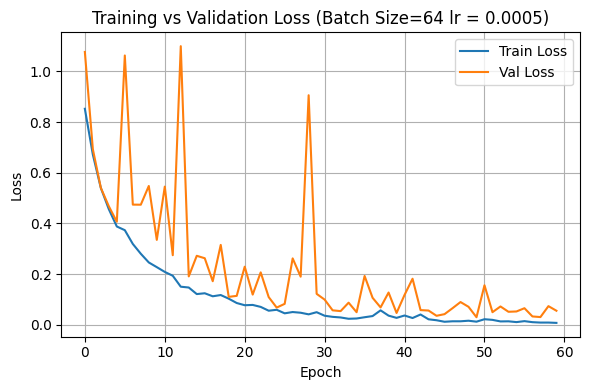

New record!
Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0005 batch size = 128
Early stopping.


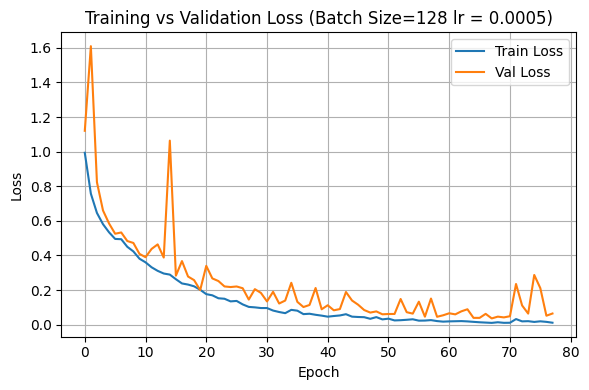

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0005 batch size = 256
Early stopping.


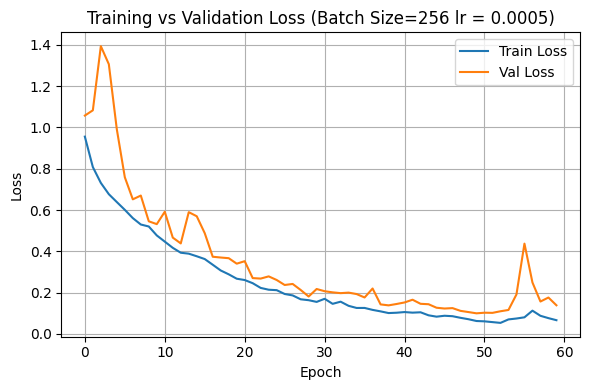

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0001 batch size = 32
Early stopping.


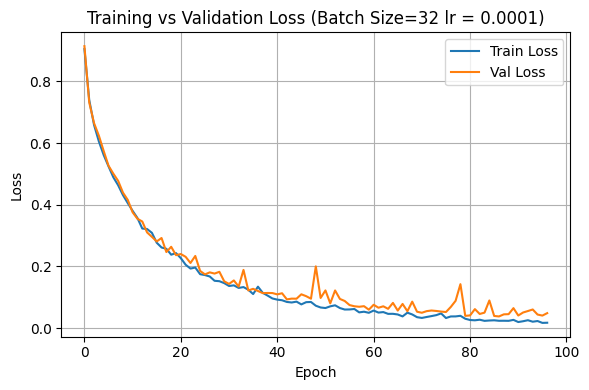

New record!
Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0001 batch size = 64
Early stopping.


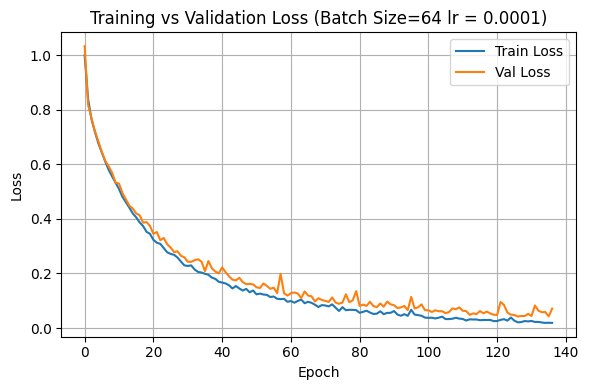

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0001 batch size = 128
Early stopping.


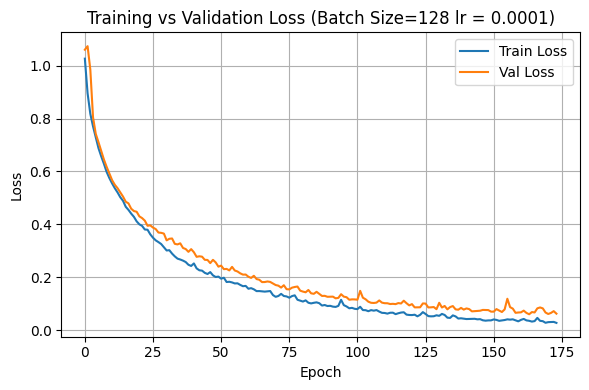

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 0.0001 batch size = 256
Early stopping.


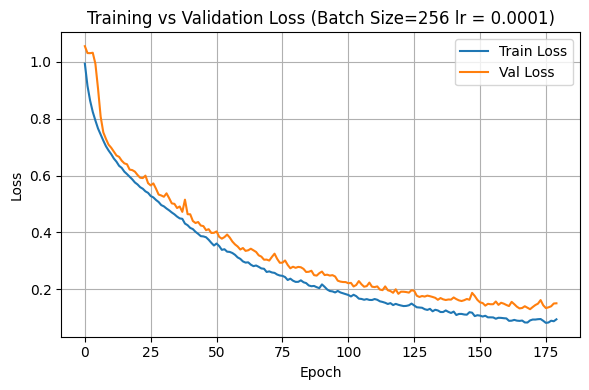

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 5e-05 batch size = 32
Early stopping.


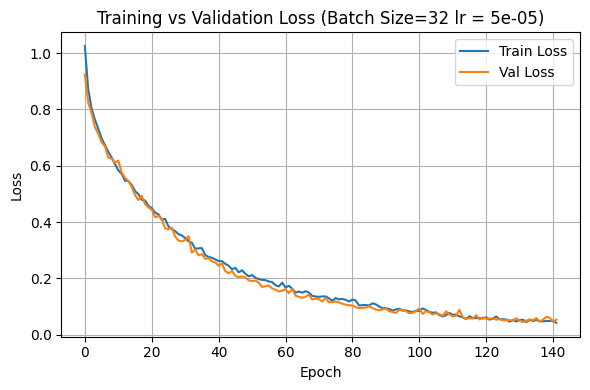

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 5e-05 batch size = 64
Early stopping.


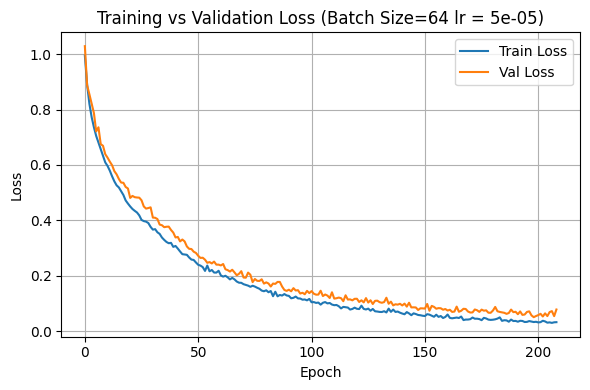

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 5e-05 batch size = 128
Early stopping.


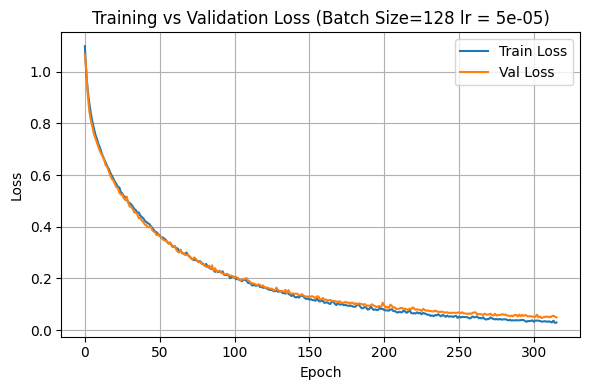

Number of samples:  2019
Total params: 30,603
Trainable params: 30,603
Training on: learning rate = 5e-05 batch size = 256
Early stopping.


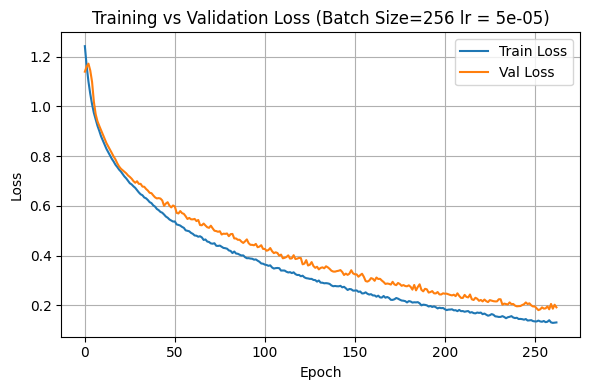

In [40]:
def train_classifier(learning_rate, batch_size):
    dataset = DuckCropDataset("data_bg")
    train_set, val_set = train_val_split(dataset)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = DuckClassifier(NUM_CLASSES).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Training on: learning rate = {learning_rate} batch size = {batch_size}")

    best_val, patience = float('inf'), 0

    val_losses = []
    train_losses = []

    for epoch in range(MAX_EPOCHS):
        model.train()
        running_loss, correct, total = 0, 0, 0
        # for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}"):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)
            loss = criterion(logits, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits = model(imgs)
                val_loss += criterion(logits, labels).item() * imgs.size(0)
                preds = logits.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # print(f"Train Loss {train_loss:.4f} Acc {train_acc:.3f} | Val Loss {val_loss:.4f} Acc {val_acc:.3f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # early stopping
        if val_loss < best_val:
            best_val = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping.")
                break
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training vs Validation Loss (Batch Size={batch_size} lr = {learning_rate})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, val_loss
    
if __name__ == "__main__":

    best_val_loss = float('inf')

    for lr in LRS:
        for bs in BATCH_SIZES:
            model, val_loss = train_classifier(lr, bs)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print("New record!")

                torch.save(model.state_dict(), 'classifier.pt')


Now Evaluating the clasifier model:

Number of samples:  2019


Accuracy: 0.985
Classification Report:
              precision    recall  f1-score   support

  background      0.990     1.000     0.995       104
        duck      1.000     0.948     0.973        58
duck_on_side      0.951     1.000     0.975        39

    accuracy                          0.985       201
   macro avg      0.981     0.983     0.981       201
weighted avg      0.986     0.985     0.985       201

Confusion Matrix:
[[104   0   0]
 [  1  55   2]
 [  0   0  39]]


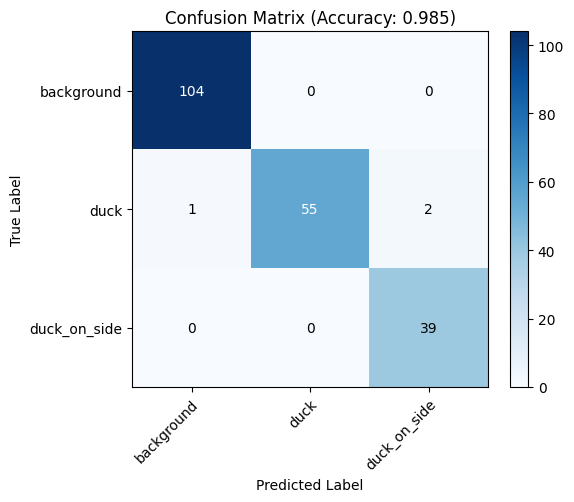

In [41]:

MODEL_PATH = "classifier.pt" # Model path from last block
DATA_DIR = "data_bg" # Dataset root. 

# Load everything. 
dataset = DuckCropDataset(DATA_DIR)
train_set, val_set = train_val_split(dataset)
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False)

model = DuckClassifier(num_classes=len(LABELS)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# Run everything. 
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(1) # Find best prediction. 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate all metrics
acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Accuracy: {acc:.3f}")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=LABELS, digits=3))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(LABELS)),
    yticks=np.arange(len(LABELS)),
    xticklabels=LABELS,
    yticklabels=LABELS,
    ylabel="True Label",
    xlabel="Predicted Label",
    title=f"Confusion Matrix (Accuracy: {acc:.3f})"
)

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

fig.tight_layout()
plt.show()

## RPN Network

Now that the classifier is trained, we can move onto training the RPN network. 

In [42]:
# First there are a bunch of helper functions to make the code way easier. 

def box_xyxy_to_cxcywh(b):
    """
    Convert from corner, corner box format to center x, center y, width height format. 
    """

    x1, y1, x2, y2 = b.unbind(-1) # Unpack box format. 
    w, h = (x2 - x1), (y2 - y1) # calculate width and height. 
    cx, cy = x1 + 0.5 * w, y1 + 0.5 * h # Calculate box center. 
    return torch.stack([cx, cy, w, h], -1)

def box_cxcywh_to_xyxy(b):
    """
    Convert from center x, center y, width height format to corner, corner box format. 
    """

    cx, cy, w, h = b.unbind(-1) # Unpack
    return torch.stack([cx - 0.5 * w, cy - 0.5 * h, cx + 0.5 * w, cy + 0.5 * h], -1) # Calculate box, and return. 

def encode_boxes(gt, an):
    """
    Used by the RPN to predict box offsets relative to anchors.
    Computes normalized deltas between ground truth boxes and anchor boxes, where gt is the ground truth, and an is the anchors. 

    Applies predicted deltas to anchor boxes to reconstruct the actual proposal boxes.
    """

    # This is just eq2 from the RCNN paper, but expressed in weirdo tensor form. 
    gt_c, an_c = box_xyxy_to_cxcywh(gt), box_xyxy_to_cxcywh(an)
    t = torch.empty_like(gt_c)
    t[..., 0] = (gt_c[..., 0] - an_c[..., 0]) / an_c[..., 2]
    t[..., 1] = (gt_c[..., 1] - an_c[..., 1]) / an_c[..., 3]
    t[..., 2:] = torch.log(gt_c[..., 2:] / an_c[..., 2:])
    return t

def decode_boxes(deltas, an):

    """
    Inverse operation from encode_boxes
    """

    an_c = box_xyxy_to_cxcywh(an)
    cx = an_c[..., 0] + deltas[..., 0] * an_c[..., 2]
    cy = an_c[..., 1] + deltas[..., 1] * an_c[..., 3]
    w, h = an_c[..., 2] * torch.exp(deltas[..., 2]), an_c[..., 3] * torch.exp(deltas[..., 3])
    return box_cxcywh_to_xyxy(torch.stack([cx, cy, w, h], -1))

def make_base_anchors(scales, ratios):

    """
    Creates base anchor shapes centered at (0,0) at the given scales and ratios. 

    The scale is the size of the rect, the ratio is the aspect ratio. 
    """

    def make_anchor(s, r):
        return [
            -s * math.sqrt(r) / 2, 
            -s / math.sqrt(r) / 2, 
            s * math.sqrt(r) / 2, 
            s / math.sqrt(r) / 2
        ]

    out = [make_anchor(scale, ratio) for scale in scales for ratio in ratios]
    return torch.tensor(out, dtype=torch.float32)

def tile_anchors(base, H, W, stride, device):

    """
    Spread a base set of tile anchors over a set width and height width a certain stride

    Also send to device. 
    """

    ys, xs = torch.arange(H, device=device) * stride, torch.arange(W, device=device) * stride
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')
    shifts = torch.stack([xx, yy, xx, yy], -1).reshape(-1, 4)
    return (base.to(device)[None, :, :] + shifts[:, None, :]).reshape(-1, 4)

def assign_rpn_targets(anchors, gt_boxes, pos_thr=0.7, neg_thr=0.3, batch_size=256, pos_frac=0.5):

    """
    Generates training labels for each anchor by calculating the IoU between anchors and ground-truth boxes.
    Marks anchors as:
        Positive (1): IoU > pos_thr
        Negative (0): IoU < neg_thr
        Ignore (-1): otherwise
    """

    # This is my attempt at implementing the algorithm talked about in section 3.1 of the RCNN paper, talking about the loss function

    # Number of anchors and device reference
    M, dev = anchors.shape[0], anchors.device
    
    labels = torch.full((M,), -1, dtype=torch.int64, device=dev) # Initialize all anchor labels to -1 (ignored)
    bbox_t = torch.zeros((M, 4), dtype=torch.float32, device=dev) # Initialize all box regression targets to zero

    # If there are no ground truth boxes, label everything as background (0)
    if gt_boxes.numel() == 0:
        labels[:] = 0
    else:
        # Compute IoU between each anchor and every ground-truth box
        iou = box_iou(anchors, gt_boxes)
 
        # For each anchor, find the best IoU and index of the GT box it matches
        max_iou, argmax = iou.max(1)
        
        labels[max_iou < neg_thr] = 0 # Label anchors with IoU below the negative threshold as background
        labels[max_iou >= pos_thr] = 1 # Label anchors with IoU above the positive threshold as foreground
        labels[iou.argmax(0)] = 1 # Ensure every GT box has at least one positive anchor (the best match)
        
        # Get indices of positive anchors
        pos_idx = (labels == 1).nonzero().squeeze(1)
        if pos_idx.numel() > 0:
            # Compute regression targets (encoded deltas) for positive anchors
            bbox_t[pos_idx] = encode_boxes(gt_boxes[argmax[pos_idx]], anchors[pos_idx])

    # Limit number of positive samples to maintain class balance
    n_pos = int(pos_frac * batch_size)
    pos_inds = (labels == 1).nonzero().squeeze(1)
    if pos_inds.numel() > n_pos:
        # Randomly set excess positives to -1 (ignore)
        labels[pos_inds[torch.randperm(pos_inds.numel(), device=dev)[n_pos:]]] = -1

    # Compute how many negatives to keep to reach total batch size
    n_neg = batch_size - (labels == 1).sum().item()
    neg_inds = (labels == 0).nonzero().squeeze(1)
    if neg_inds.numel() > n_neg:
        # Randomly set excess negatives to -1 (ignore)
        labels[neg_inds[torch.randperm(neg_inds.numel(), device=dev)[n_neg:]]] = -1

    # Return the final labels and corresponding regression targets
    return labels, bbox_t

class TinyRPN(nn.Module):
    def __init__(self, anchor_scales=(32, 64, 128), anchor_ratios=(0.5, 1.0, 2.0)):
        super().__init__()
        # backbone first
        self.backbone = TinyBackbone()
        self.stride = 8  # output stride of backbone (roughly 2×2×2 downsampling)
        self.anchor_scales = list(anchor_scales)
        self.anchor_ratios = list(anchor_ratios)
        
        A = len(anchor_scales) * len(anchor_ratios)
        
        # RPN head on top of backbone features
        self.conv = nn.Conv2d(self.backbone.out_channels, 256, 3, padding=1)
        self.obj_logits = nn.Conv2d(256, A, 1)
        self.bbox_deltas = nn.Conv2d(256, 4 * A, 1)
        
        self.register_buffer("base_anchors", make_base_anchors(anchor_scales, anchor_ratios))

    def forward(self, x):
        # Calculate features. 
        feats = self.backbone(x)
        
        # Apply RPN regression head. 
        x = F.relu(self.conv(feats))
        logits = self.obj_logits(x)
        bbox_deltas = self.bbox_deltas(x)
        
        return logits, bbox_deltas, feats  # return features for later ROI head
        
    def anchors_for(self, feat):
        """
        Get an initial set of anchors for the given feature map.
        """

        _, _, H, W = feat.shape
        return tile_anchors(self.base_anchors, H, W, self.stride, feat.device)

    def loss(self, logits, deltas, anchors, targets):

        """
        Calcualte the loss function given the bbox deltas, the achors, and the target bboxes. 
        """

        N, A, H, W = logits.shape
        M = H * W * A
        obj = logits.permute(0, 2, 3, 1).reshape(N, M)
        box = deltas.permute(0, 2, 3, 1).reshape(N, M, 4)
        loss_obj = loss_reg = 0.0
        for i in range(N): # Loop over all the boxes
            gt = targets[i]["boxes"].to(anchors.device)
            labels, bbox_t = assign_rpn_targets(anchors, gt) # Calculate IOU
            keep, pos = labels != -1, labels == 1
            if keep.any():
                loss_obj += F.binary_cross_entropy_with_logits(obj[i, keep], labels[keep].float())
            if pos.any():
                loss_reg += F.smooth_l1_loss(box[i, pos], bbox_t[pos], reduction='sum') / (pos.sum() + 1e-6)
        return loss_obj / N, loss_reg / N

    @torch.no_grad()
    def proposals(self, logits, deltas, feat, img_hw, pre_nms_topk=600, post_nms_topk=100, score_thresh=0.05, nms_thresh=0.7):

        device = logits.device
        N, A, H, W = logits.shape # batch size, anchors per cell, feature map height & width

        anchors = self.anchors_for(feat) # Generate all anchors for this feature map → [M,4]
        M = anchors.shape[0]

        # Reshape predicted logits and deltas to align with anchors
        scores = torch.sigmoid(logits.permute(0,2,3,1).reshape(N, M)) # Convert objectness logits to probabilities [N,M]
        delts  = deltas.permute(0,2,3,1).reshape(N, M, 4) # Bounding box regression deltas [N,M,4]

        out = []  # store proposals per image
        Himg, Wimg = img_hw  # original image height and width

        for i in range(N):
            s = scores[i]
            keep = s > score_thresh  # Filter out low-confidence anchors
            if keep.sum() == 0:
                out.append(torch.zeros((0,4), device=device))
                continue

            # Keep only anchors and deltas passing the score threshold
            s = s[keep]
            an = anchors[keep]
            d = delts[i, keep]

            # Decode predicted boxes from anchor+deltas representation
            boxes = decode_boxes(d, an)

            # Clip boxes to image boundaries
            boxes[:, 0::2] = boxes[:, 0::2].clamp(0, Wimg-1)
            boxes[:, 1::2] = boxes[:, 1::2].clamp(0, Himg-1)

            # Keep only top pre-NMS boxes by confidence
            if s.numel() > pre_nms_topk:
                v, idx = s.topk(pre_nms_topk)
                s = v
                boxes = boxes[idx]

            # Apply Non-Maximum Suppression to remove overlapping boxes
            keep_idx = nms(boxes, s, nms_thresh)

            # Keep only top boxes after NMS
            keep_idx = keep_idx[:post_nms_topk]
            out.append(boxes[keep_idx])

        # Return list of proposal tensors (one per image)
        return out


## RPN Training Loop

In [59]:
BATCH_SIZES = [128, 256]
LRS = [1e-3, 1e-4, 1e-5]
EPOCHS = 500
EARLY_STOP_PATIENCE = 10

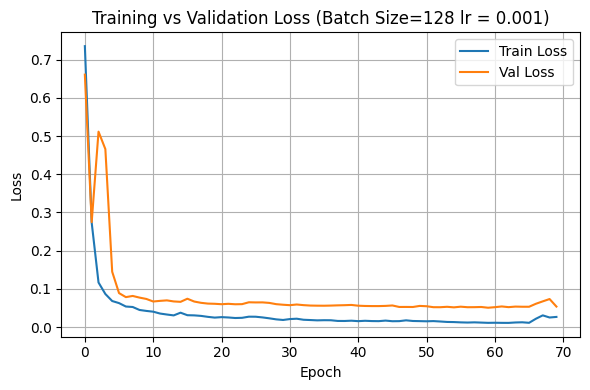

New record!


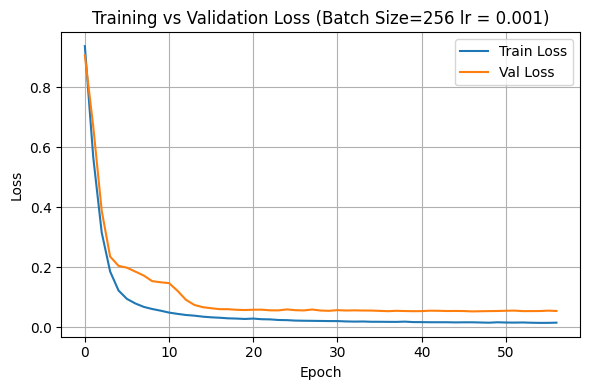

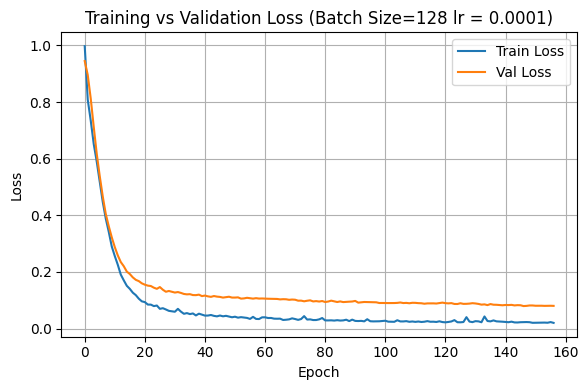

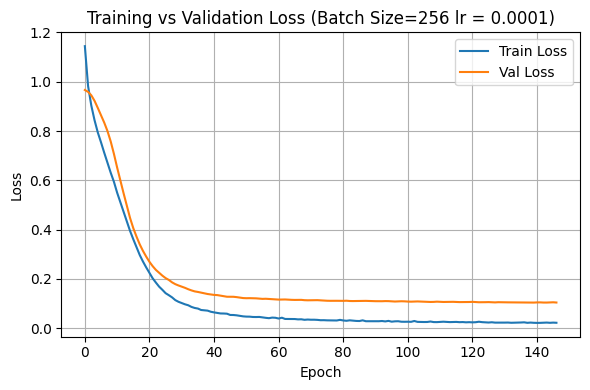

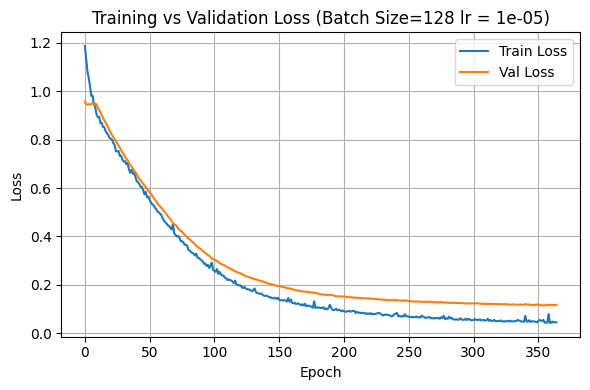

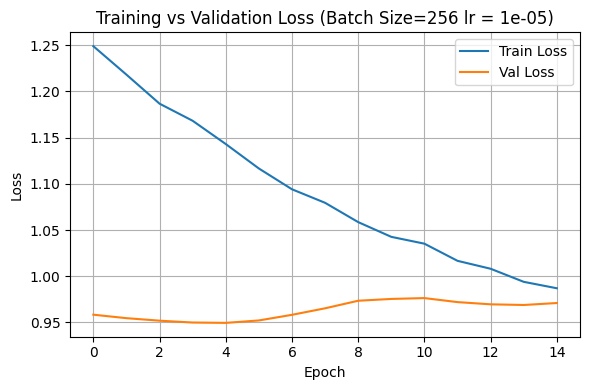

In [70]:
def collate_fn(batch):
    imgs, tars = zip(*batch)
    return torch.stack(imgs), list(tars)

def train_rpn(learning_rate, batch_size):

    # Build the dataloader. 
    ds = DuckRegionDataset("data_bg", image_size=IMAGE_SIZE)
    train_ds, val_ds = train_val_split(ds)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=batch_size, collate_fn=collate_fn)

    # Make the rpn
    rpn = TinyRPN().to(DEVICE)

    opt = torch.optim.Adam(rpn.parameters(), lr=learning_rate)

    best_val_loss, patience = float('inf'), 0

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):

        rpn.train()
        train_loss = 0

        # Run the training loop. 
        for imgs, targets in train_loader:

            imgs = imgs.to(DEVICE)

            logits, deltas, feats = rpn(imgs)

            # Generate anchors. 
            anchors = rpn.anchors_for(feats)
            # Eval loss. 
            loss = rpn.loss(logits, deltas, anchors, targets)

            # Calculate joing loss of regression and object parts of the RPN
            l_obj, l_reg = rpn.loss(logits, deltas, anchors, targets)
            loss = l_obj + l_reg

            # Backprop
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += (l_obj + l_reg).item()

        train_loss /= len(train_loader)

        # Validation. Same deal as above, but no backprop. 
        rpn.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, targets in val_loader:

                imgs = imgs.to(DEVICE)

                logits, deltas, feats = rpn(imgs)

                anchors = rpn.anchors_for(feats)
                l_obj, l_reg = rpn.loss(logits, deltas, anchors, targets)
                val_loss += (l_obj + l_reg).item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # print(f"Epoch {epoch+1}: train {train_loss:.4f} val {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss, patience = val_loss, 0
        else:
            patience += 1
            if patience >= EARLY_STOP_PATIENCE:
                break


    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training vs Validation Loss (Batch Size={batch_size} lr = {learning_rate})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rpn, val_loss
    
if __name__ == "__main__":

    best_val_loss = float('inf')

    for lr in LRS:
        for bs in BATCH_SIZES:
            model, val_loss = train_rpn(lr, bs)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print("New record!")

                torch.save(model.state_dict(), 'rpn_best.pt')

Then finally, we can run the total model, and see how well it does:

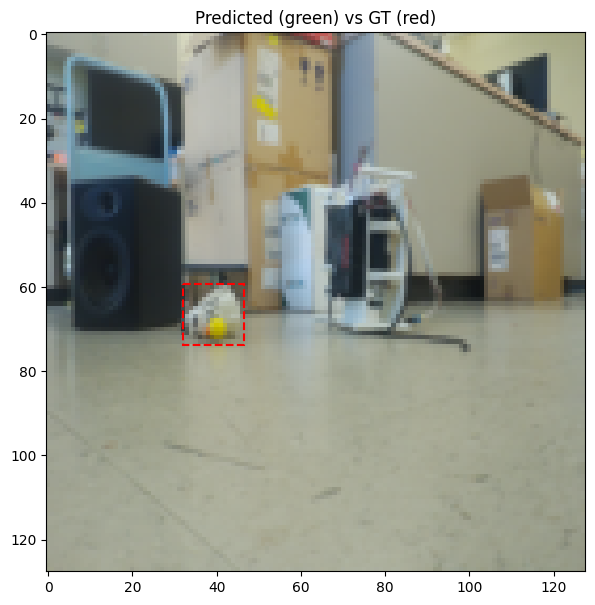

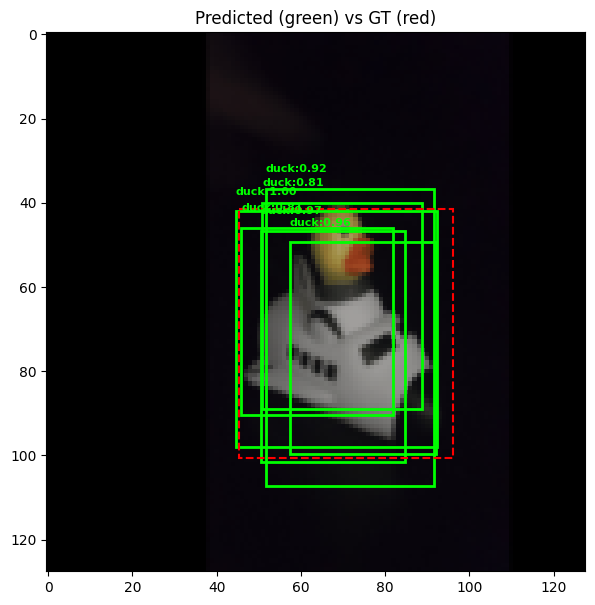

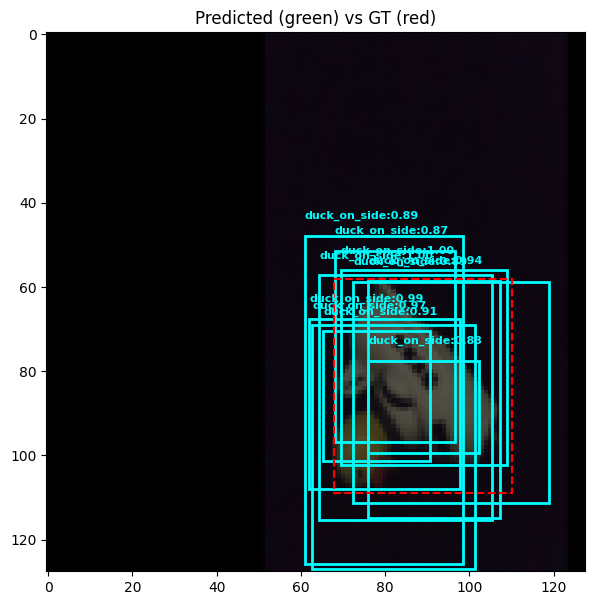

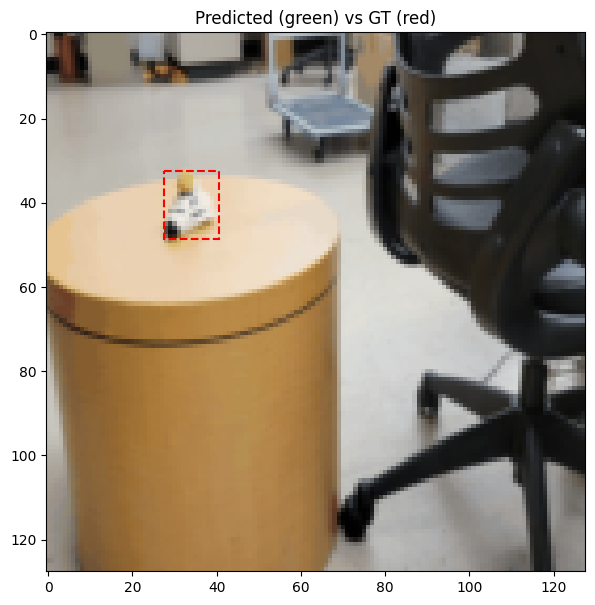

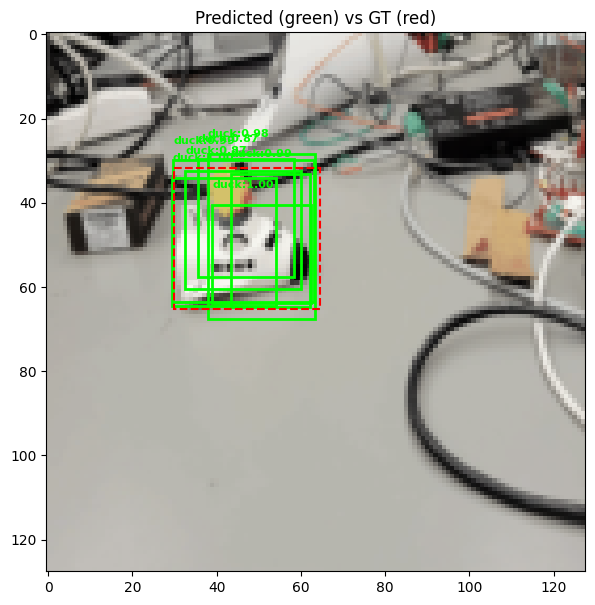

In [72]:
# Final Eval Script! 
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader

DATA_DIR = "data_bg"
BATCH_SIZE = 1

# Load the dataset.
ds = DuckRegionDataset(DATA_DIR, image_size=IMAGE_SIZE, augment=False)
train_split, val_split = train_val_split(ds)
# Use the val split for the evaluation
loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# RPN
MODEL_PATH = "rpn_best.pt"
rpn = TinyRPN().to(DEVICE)
rpn.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
rpn.eval()


# classifier 
MODEL_PATH = "classifier.pt"
classifier = DuckClassifier(num_classes=len(LABELS)).to(DEVICE)
classifier.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
classifier.eval()


@torch.no_grad()
def visualize_predictions(num_images=5, conf_thresh = .8):

    # Loop over all images in the loader
    for i, (imgs, targets) in enumerate(loader):

        if i >= num_images:
            break # Break when we have rendered enough images. 
        imgs = imgs.to(DEVICE)

        logits, deltas, feat = rpn(imgs) # Run the RPN node to get regions. 

        # Parse out proposed regions using NMS
        proposals = rpn.proposals(logits, deltas, feat, img_hw=(IMAGE_SIZE, IMAGE_SIZE),
                                  pre_nms_topk=600, post_nms_topk=20, score_thresh=0.05)

        # Convert image to numpy array. 
        img = imgs[0].permute(1,2,0).cpu().numpy()
        img_pil = Image.fromarray((img * 255).astype(np.uint8)) # Keep pil copy for rendering. 
        boxes = proposals[0].cpu() # Parse out the bounding boxes. 

        # classify each proposal
        preds, confs, kept_boxes = [], [], []
        for (x1, y1, x2, y2) in boxes.cpu(): # Loop through all boxes. 

            crop = img_pil.crop((x1.item(), y1.item(), x2.item(), y2.item())) # Crop out the area in question. 

            crop_t = TF.resize(TF.to_tensor(crop), (IMAGE_SIZE, IMAGE_SIZE)).unsqueeze(0).to(DEVICE) # Cnonvert to tensor of the correct size. 
            logits = classifier(crop_t) # Run the classifier. 
            probs = F.softmax(logits, dim=1)[0] # Get the probabilities through a softmax
            conf, pred = probs.max(dim=0) # Get the max probability
            if pred.item() in [1, 2] and conf.item() >= conf_thresh: # if its not background, and above our threshold, keep going. 
                preds.append(pred.item())
                confs.append(conf.item())
                kept_boxes.append((x1, y1, x2, y2))

        # plotting 
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(img)
        for (x1, y1, x2, y2), p, c in zip(kept_boxes, preds, confs):
            color = 'lime' if p == 1 else 'cyan'
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                fill=False, color=color, linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1-4, f"{LABELS[p]}:{c:.2f}", color=color, fontsize=8, weight="bold")

        # Add true labels. 
        if len(targets[0]["boxes"]) > 0:
            for b in targets[0]["boxes"]:
                x1,y1,x2,y2 = b.tolist()
                rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=1.5,
                                         edgecolor='red', facecolor='none', linestyle='--')
                ax.add_patch(rect)

        ax.set_title(f"Predicted (green) vs GT (red)")
        plt.show()

if __name__ == "__main__":
    visualize_predictions()


Sooooo not exactly perfect. But we are getting there! The model is clearly starting to learn to identify where ducks are in the scene. With a bit of polishing to the overall architecture (and a lot more data), we should be able to create a much more effective network. 